In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import networkx as nx
import sounddevice as sd

In [2]:
P = 20
L = 20
d_max = 10
BS = [P/2, L/2]

N = 200
m = 15
kc = 25
kd = 250
kt = kd + N
beta = 0.8
data_rate = 500 # bps
t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
initial_energy = 5
E_elec = 50 * 1e-9
E_amp =  10 * 1e-5
E_fs = 10*1e-12
E_mp = 0.0013*1e-12
p = 0.05
DECKS_threshold = 3

EPOCH = 100
GAMMA = 0.1
ALPHA = 0.01
EPSILON = 0.2

In [3]:
def generate_sound(frequency, duration, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    audio = np.sin(2 * np.pi * frequency * t)
    return audio

def play_sound(sound, sample_rate=44100):
    sd.play(sound, samplerate=sample_rate)
    sd.wait()

# Set the frequency and duration of the sound
desired_frequency = 880  # Change this to your desired frequency in Hz
desired_duration = 1      # Change this to your desired duration in seconds

# Generate the sound
sound = generate_sound(desired_frequency, desired_duration)



In [4]:
def ratio_delay(distance):
    v = 3 * 1e8
    t = distance/v
    a = t/t_transmission
    # print(f"Ratio delay : {a:.2f} | T_tranmission : {t_transmission:.2f} | T_uw : {t_uw:.2f}")
    return a

def throughput(a):
    numerator = kc * np.exp(-a * kc)
    denominator = kc * (1 + 2 * a) + np.exp(-a * kc)
    rho = numerator / denominator
    # print(f"Throughput : {rho:.2f} | numerator : {numerator:.2f} | denominator : {denominator:.2f}")
    return rho


class Node:
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.energy = initial_energy
        self.nϵG = False
        self.alive = True
        self.CH = False
        self.which_cluster = 0
        self.eligible_round = 0
        self.cluster_class = 0
        self.id = id

    def distance(self, other_node):
        return np.sqrt((self.x - other_node.x)**2 + (self.y - other_node.y)**2)

    def reset(self):
        self.CH = False
        self.which_cluster = 0

    def advertisement(self, count_cluster, eligible_round):
        self.CH = True
        self.nϵG = False
        self.eligible_round = eligible_round
        self.which_cluster = count_cluster

    def energySelection(self, d_CH_BS, p):
        # If node selected as a CH
        a = ratio_delay(d_CH_BS)
        rho = throughput(a)
        first_term = (kc / rho) * (E_elec + E_amp * (d_CH_BS**2))
        second_term = (p * (N - 1) / rho) * (beta * E_elec * kc)
        third_term = E_elec * kt
        E_Selection = first_term + second_term + third_term
        return E_Selection

    def energyIdle(self):
        return beta * E_elec * kc

    def energyAdvertisement(self):
        # Broadcasting to all nodes in the range of d_max, occurs only for CH
        return kc * (E_elec + E_amp * (d_max**2))

    def energyJoin(self, p):
        # Node receive the broadcasting message and decide whether want to join as a associated node for CH i-th
        return p * N * kc * E_elec

    def energy_contention_TDMA_CH(self, Nc):
        return kc * Nc * E_elec + kt * (E_elec + E_amp * (d_max**2))

    def energy_contention_TDMA_Node(self, d_CH_Node):
        a = ratio_delay(d_CH_Node)
        rho = throughput(a)
        energy = (kc / rho) * (E_elec + E_amp * (d_CH_Node**2)) + ((N-1)/ rho) * kc * beta * E_elec + kt * E_elec
        return energy

    def energyFrame_CH(self, Nc, d_CH_BS):
        return m * Nc * kd * E_elec * beta * kd * E_elec + kd * (E_elec +  E_amp * (d_CH_BS**2))

    def energyFrame_Node(self, d_CH_Node):
        return m * kd * E_elec * (E_elec + E_elec +  E_amp * (d_CH_Node**2))


In [5]:
def createNetworks(N, P, L):
    areaTotal = P * L

    #Point process parameters
    lambda0 = N/(P * L)

    #Simulate a Poisson point process
    numbPoints = np.random.poisson(lambda0 * areaTotal)
    xx = P * np.random.uniform(0,1,numbPoints)
    yy = L * np.random.uniform(0,1,numbPoints)

    nodes = []
    nodes.append(Node(P//2, L//2, 0))

    for i in range(len(xx)):
        nodes.append(
            Node(xx[i], yy[i], i + 1)
        )

    return nodes

In [6]:
class multiHop(object):
    def __init__(self,graph):
        self.graph = graph
        self.adjacent_mat = nx.adjacency_matrix(graph).todense()
        self.num_nodes = len(self.adjacent_mat)
        self.adjacent_mat = nx.adjacency_matrix(graph, nodelist=range(self.num_nodes)).toarray()#:D
        # print(f"\n Adjacent Matrix \n{self.adjacent_mat}\n")

    def q_learning(self,start_state=0, aim_state = 10, num_epoch=200, gamma=0.8, epsilon=0.05, alpha=0.1):
        rewards = self.adjacent_mat.copy()
        q_table = np.full((self.num_nodes, self.num_nodes), 100)  # Initialize Q-table with 100
        td = []
        for episode in range(1, num_epoch + 1):
            count = 0
            #print(f"========================================================================== Episode : {episode} =========================================================================")
            current_state = start_state

            while True:
                next_state = self.epsilon_greedy(current_state, q_table, start_state, aim_state, epsilon=epsilon)
                reward = rewards[current_state][next_state]
                delta = reward + gamma * np.min(q_table[next_state]) - q_table[current_state, next_state]

                q_table[current_state, next_state] = q_table[current_state, next_state] + alpha * delta
                q_table[current_state, next_state] = round(q_table[current_state, next_state], 5)
                # update current state
                current_state = next_state
                td.append(delta)
                count += 1
                if ((current_state == aim_state) or (count > 100)):
                    break
                # print(f"\t\tstart state : {start_state} | episode : {episode} | count : {count}")
            # print(f"start state : {start_state} | episode : {episode} | count : {count}")

        shortest_path = self.calculate_shortest_path(q_table, start_state, aim_state)
        return shortest_path, td

    def calculate_shortest_path(self, q_table, start_state, aim_state):
        current_state = start_state
        shortest_path = [current_state]
        max_iterations = self.num_nodes  # Setting a maximum number of iterations to avoid infinite loops

        while current_state != aim_state and max_iterations > 0:
            next_state = np.argmin(q_table[current_state])
            shortest_path.append(next_state)
            current_state = next_state
            max_iterations -= 1

        if max_iterations <= 0:
            shortest_path = [start_state]
            print(f"unreachable {start_state}=> {shortest_path}")
            # Handle this situation accordingly, such as returning None or an empty path
        # print(f"Start : {start_state} => {shortest_path}")
        return shortest_path
    
    def epsilon_greedy(self,s_curr, q, start_state, aim_state, epsilon):
        potential_next_states = np.where(np.array(self.adjacent_mat[s_curr]) <= d_max)[0]
        potential_next_states = potential_next_states[potential_next_states != start_state]
        if len(potential_next_states) != 0:
            # print("potential_next_states != 0")
            if random.random() > epsilon:
                q_of_next_states = q[s_curr][potential_next_states]
                s_next = potential_next_states[np.argmin(q_of_next_states)]
            else:
                s_next = random.choice(potential_next_states)
            return s_next
        else:
            # print("potential_next_states = 0")
            return aim_state


class networkEnvironment:
    def __init__(self, nodes, mode, showInfo, showPlotIteration):
        self.nodes = nodes
        self.mode = mode
        self.alive_data = []
        self.energy_data = []
        self.node_failure = []
        self.packet_delivered = []
        self.data_sent = 0
        self.centroids = np.array([[P//2, L//2]])
        self.showInfo = showInfo
        self.showPlotIteration = showPlotIteration
        self.multihop_path = []
        self.optimal_k = 0
    
    def showResult(self, hop):
        fig, ax = plt.subplots(1, 4, figsize=(20,5))
        rounds = np.array([i for i in range(0, len(self.alive_data))])
        self.alive_data = np.array(self.alive_data)
        self.energy_data = np.array(self.energy_data)
        self.node_failure = np.array(self.node_failure)

        ax[0].plot(rounds, self.alive_data, color='k')
        ax[0].scatter(rounds[::hop], self.alive_data[::hop], marker='o', edgecolor='k', color='r')
        ax[0].set_ylabel("Node Alive")
        ax[0].set_xlabel("Round")

        ax[1].plot(rounds, self.energy_data, color='k')
        ax[1].scatter(rounds[::hop], self.energy_data[::hop], marker='o', edgecolor='k', color='r')
        ax[1].set_ylabel("Energy Consumed")
        ax[1].set_xlabel("Round")

        ax[2].plot(rounds, self.node_failure, color='k')
        ax[2].scatter(rounds[::hop], self.node_failure[::hop], marker='o', edgecolor='k', color='r')
        ax[2].set_ylabel("Node Failure")
        ax[2].set_xlabel("Round")

        ax[3].plot(rounds, self.packet_delivered, color='k')
        ax[3].scatter(rounds[::hop], self.packet_delivered[::hop], marker='o', edgecolor='k', color='r')
        ax[3].set_ylabel("Node Failure")
        ax[3].set_xlabel("Round")

        ax[0].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.alive_data))/20))
        ax[0].yaxis.set_major_formatter('{x:.2f}')
        ax[0].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.alive_data))/30))
        ax[0].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        ax[0].xaxis.set_major_formatter('{x:.2f}')
        ax[0].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))
        
        ax[1].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.energy_data))/20))
        ax[1].yaxis.set_major_formatter('{x:.2f}')
        ax[1].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.energy_data))/30))
        ax[1].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        ax[1].xaxis.set_major_formatter('{x:.2f}')
        ax[1].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))

        # ax[2].yaxis.set_major_locator(MultipleLocator(np.abs(np.max(self.node_failure))/10))
        # ax[2].yaxis.set_major_formatter('{x:.2f}')
        # ax[2].yaxis.set_minor_locator(MultipleLocator(np.abs(np.max(self.node_failure))/20))
        # ax[2].xaxis.set_major_locator(MultipleLocator(np.max(rounds)/5))
        # ax[2].xaxis.set_major_formatter('{x:.2f}')
        # ax[2].xaxis.set_minor_locator(MultipleLocator(np.max(rounds)/10))


    def showNetwork(self, simulation_round):
        fig, ax = plt.subplots()
        ax.clear()
        normal_nodes = {'x':[], 'y':[]}
        orphan_nodes = {'x':[], 'y':[]}
        CH_nodes = {'x':[], 'y':[]}
        BS_node = {'x':[], 'y':[]}
        dead_nodes = {'x':[], 'y':[]}
        energy = 0
        node_alive = 0
        count_CH = 0

        for node in self.nodes:
            normal_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster != 0) and (node.energy > 0))
            orphan_node_status = ((node.id != 0) and (node.CH == False) and (node.which_cluster == 0) and (node.energy > 0))
            CH_node_status = ((node.id != 0) and (node.CH == True) and (node.alive) and (node.energy > 0))
            dead_node_status = ((node.id != 0) and (node.energy < 0) and (node.alive != True))
            if normal_node_status:
                normal_nodes['x'].append(node.x)
                normal_nodes['y'].append(node.y)
            if orphan_node_status:
                orphan_nodes['x'].append(node.x)
                orphan_nodes['y'].append(node.y)
            if CH_node_status:
                CH_nodes['x'].append(node.x)
                CH_nodes['y'].append(node.y)
                count_CH += 1
            if node.id == 0:
                BS_node['x'].append(node.x)
                BS_node['y'].append(node.y)
            if dead_node_status:
                dead_nodes['x'].append(node.x)
                dead_nodes['y'].append(node.y)
            if node.alive:
                energy += node.energy
                node_alive += 1
            if self.showInfo:
                ax.annotate(f"{node.energy:.2f}\n({node.id})", (node.x, node.y), textcoords="offset points", xytext=(2, 6), ha='center', fontsize=7)

        energy = np.round(energy, 2)
        ax.scatter(normal_nodes['x']    , normal_nodes['y']       , marker="o",color='purple' , edgecolors='k', label = "Node")
        ax.scatter(orphan_nodes['x']    , orphan_nodes['y']       , marker="o",color='c'      , edgecolors='k', label = "Orphan Node")
        ax.scatter(CH_nodes['x']        , CH_nodes['y']           , marker="o",color="g"      , edgecolors='k', label = "Cluster Head")
        ax.scatter(dead_nodes['x']      , dead_nodes['y']         , marker="x",color='r'      , label="Dead Node")
        ax.scatter(BS_node['x']         , BS_node['y']            , marker="s",color="b"      , edgecolors='k', label="Base station", s=50)

        font = {
                'color':  'black',
                'weight': 'bold'
                }

        if ((self.mode == "Q-Learning") and (len(self.multihop_path) != 0)):
            for index_path in range(len(self.multihop_path)-1):
                # print(f"{index_path} | Path : {len(self.multihop_path)} | Node : {len(self.nodes)}")
                start_x = self.nodes[self.multihop_path[index_path+1]].x  # Reversed start_x and end_x
                start_y = self.nodes[self.multihop_path[index_path+1]].y  # Reversed start_y and end_y
                end_x = self.nodes[self.multihop_path[index_path]].x
                end_y = self.nodes[self.multihop_path[index_path]].y
                dx = start_x - end_x
                dy = start_y - end_y
                ax.quiver(end_x, end_y, dx, dy, angles='xy', scale_units='xy', scale=1, width=0.005)

        if ((self.mode == "DECKS") or (self.mode == "K-Means") or (self.mode == "Q-Learning")):
            if count_CH != 0:
                ax.scatter(self.centroids[:,0]  , self.centroids[:,1]     , marker="o",color="y"      , edgecolors='k', label="Centroid")
            ax.set_title(f'Round : {simulation_round} | E : {energy} | CH : {count_CH} | Opt k : {self.optimal_k}', fontdict=font)
        else:
            ax.set_title(f'Round : {simulation_round} | E : {energy} | CH : {count_CH}', fontdict=font)
        ax.set_xlabel('Length (m)')
        ax.set_ylabel('Width (m)')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5, markerscale=1, fontsize=10)
        plt.tight_layout()
        plt.show()

    def multiHopRouting(self, node):
        # Creatubg ab Adjacency Matrix for Q-Learning
        status = (
                (node.energy > 0) and 
                (node.alive == True) and
                (node.id != 0)
            )
        G = nx.Graph()
        for nodeA in self.nodes:
            for nodeB in self.nodes:
                if ((nodeA.id != nodeB.id) and (status)) :
                    distances = self.euclidean_distance(np.array([nodeA.x, nodeA.y]), np.array([nodeB.x, nodeB.y]))
                    G.add_edge(nodeA.id, nodeB.id, weight=distances)

        Q_learning = multiHop(G)
        paths, _ = Q_learning.q_learning(start_state=node.id, aim_state = 0, num_epoch=EPOCH, gamma=GAMMA, epsilon=EPSILON, alpha=ALPHA)
        # print(f"Node : {node.id} => Paths : {paths}")
        return paths
    
    def euclidean_distance(self, nodeA, nodeB):
        return np.sqrt(np.sum((nodeA - nodeB)**2))
        
    def Nc(self, which_cluster):
        count = 0
        for node in self.nodes:
            if node.which_cluster == which_cluster:
                count += 1
        return count
    
    def LEACH(self, round_number):
        for node in self.nodes:
            d_CH_BS = self.euclidean_distance(np.array([node.x, node.y]), np.array(BS))
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.eligible_round == 0) and
                (d_CH_BS < d_max)
            )
            threshold = random.uniform(0, 1) <= p/(1-p * (round_number % (1/p)))
            if ((status) and (threshold)):
                node.CH = True
                node.which_cluster = node.id
                node.eligible_round = 1/p
    
    def kmeans_plusplus(self, X, k):
        centroids = []
        centroids.append(X[np.random.randint(X.shape[0])])

        for _ in range(1, k):
            distances = np.array([min([np.linalg.norm(x - c) for c in centroids]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_probabilities = probabilities.cumsum()
            r = np.random.rand()
            i = 0
            for j, p in enumerate(cumulative_probabilities):
                if r < p:
                    i = j
                    break
            centroids.append(X[i])

        return np.array(centroids)

    def kmeans(self, X, k, iteration=100):
        # Memilih random k centroid sebagai nilai awal
        centroids = self.kmeans_plusplus(X, k)

        for i in range(iteration):
            # Euclidian Distance
            distances = np.linalg.norm(X[:, None, :] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            # Mengupdate nilai Centroid
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            centroids = new_centroids

        return centroids, labels
    
    def kmeans_LEACH(self):                    
        X, id = [], []
        for node in self.nodes:
            if ((node.id != 0) and (node.alive) and (node.energy > 0)) :
                X.append([node.x, node.y])
                id.append(node.id)

        X = np.array(X)
        if len (X) != 0 :
            elbow = []
            max_k = 15  # Maximum number of clusters to try
            for k in range(1, max_k + 1):
                centroids, labels = self.kmeans(X, k)
                error = np.sum((X - centroids[labels])**2)
                elbow.append(error)

            # Calculate the change in distortions and find the elbow point
            elbow = np.array(elbow)
            elbow_diff = np.diff(elbow, prepend=elbow[0])
            acceleration = np.diff(elbow_diff, prepend=elbow_diff[0])
            self.optimal_k = np.argmax(acceleration)
            self.centroids, labels = self.kmeans(X, self.optimal_k)

            ch_id = []
            for ch in self.centroids:
                distances = [[], []]
                for node in self.nodes:
                    if ((node.id != 0) and (node.energy > 0) and (node.alive)):
                        X = np.array([node.x, node.y])
                        CH = np.array([ch[0], ch[1]])
                        distances[0].append(self.euclidean_distance(X, CH))
                        distances[1].append(node.id)

                ch_id.append(distances[1][np.argmin(distances[0])])

            for node in self.nodes:
                if node.id != 0:
                    for id in ch_id:
                        if node.id == id:
                            node.CH = True
                            node.which_cluster = id

    def DECKS_LEACH(self, DECKS_threshold):                    
        X, id = [], []
        for node in self.nodes:
            if ((node.id != 0) and (node.alive) and (node.energy > 0)) :
                X.append([node.x, node.y])
                id.append(node.id)

        X = np.array(X)
        if len (X) != 0 :
            elbow = []
            max_k = 15  # Maximum number of clusters to try
            for k in range(1, max_k + 1):
                centroids, labels = self.kmeans(X, k)
                error = np.sum((X - centroids[labels])**2)
                elbow.append(error)

            # Calculate the change in distortions and find the elbow point
            elbow = np.array(elbow)
            elbow_diff = np.diff(elbow, prepend=elbow[0])
            acceleration = np.diff(elbow_diff, prepend=elbow_diff[0])
            self.optimal_k = np.argmax(acceleration)
            self.centroids, labels = self.kmeans(X, self.optimal_k)

            labels = np.array(labels)
            number_of_clusters = np.unique(labels)

            for cluster in number_of_clusters:
                count = 0
                within_cluster = []
                for label in labels:
                    if label == cluster:
                        within_cluster.append(self.nodes[count])
                    count += 1

                nearest_distance = []
                for node_i in within_cluster:
                    sum_euclidian = 0
                    for node_j in within_cluster:
                        if ((node_i != node_j) and (node_i.energy > DECKS_threshold) and (node_j.energy > 0)):
                            sum_euclidian += self.euclidean_distance(np.array([node_i.x, node_i.y]), np.array([node_j.x, node_j.y]))
                    nearest_distance.append(sum_euclidian)

                nearest_distance = np.array(nearest_distance)
                CH_id = within_cluster[np.argmin(nearest_distance)]
                for node in self.nodes:
                  if node.id == CH_id.id :
                      node.CH = True
                      node.which_cluster = node.id


    def CH_selection(self, round_number):
        for node in self.nodes:
            node.reset()
            
        if self.mode == "LEACH":
            self.LEACH(round_number)
        elif self.mode == "Q-Learning":
            self.DECKS_LEACH(0.05)
        elif self.mode == "K-Means":
            self.kmeans_LEACH()
        elif self.mode == "DECKS":
            self.DECKS_LEACH(DECKS_threshold)
        
        CHs = [node for node in self.nodes if node.CH]
        for node in self.nodes:
            status = ((node.energy > 0) and (node.alive == True) and (node.id != 0) and (node.CH != True))
            if len(CHs):
                distances = [[], []]
                if status:
                    for CH in CHs:
                        distances[0].append(self.euclidean_distance(np.array([node.x, node.y]), np.array([CH.x, CH.y])))
                        distances[1].append(CH.which_cluster)
                    if distances[0][np.argmin(distances[0])] > d_max:
                        node.which_cluster = 0
                    else:
                        node.which_cluster = distances[1][np.argmin(distances[0])]
            if len(CHs) <= 0:
                # Jika tidak ada yang terpilih sebagai CH, maka node akan diam
                if node.id != 0:
                    node.which_cluster = 0

        if round_number % self.showPlotIteration == 0:
            self.showNetwork(round_number)
            
    def SetupPhase(self, simulation_round):
        # CH Selection and Advertisement Energy Dissipation and Creating TDMA Schedule
        # Node Join Energy Dissipation and join TDMA Schedule
        self.CH_selection(simulation_round)
        CHs = [node for node in self.nodes if node.CH]
        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.id != 0) and 
                (node.which_cluster != 0)
            )
            if status:
                if node.CH:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y]), np.array([BS[0], BS[1]]))
                    energy_dissipated = node.energyAdvertisement() + node.energySelection(d_CH_BS, len(CHs)/N) + node.energy_contention_TDMA_CH(Nc)
                    node.energy = node.energy - energy_dissipated
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y]), np.array([CH.x, CH.y]))
                            energy_dissipated = node.energy_contention_TDMA_Node(d_CH_Node) + node.energyJoin(len(CHs)/N)
                            node.energy = node.energy - energy_dissipated
            
            if ((node.energy > 0) and (node.which_cluster == 0)):
                # If node is not in cluster, it become idle
                node.energy -= node.energyIdle()
                
            if node.energy < 0:
                if self.showInfo:
                    print(f"\tNode dead found during Setup phase at round - Ronde :  {simulation_round} \nNode id-{node.id} | E : {node.energy} | CH : {node.CH} | Cluster : {node.which_cluster}")
                node.alive = False
    
    def SteadyStatePhase(self, simulation_round):
        CHs = []
        energy_total = 0
        node_alive = 0
        node_failure = 0


        for node in self.nodes:
            status = (
                (node.energy > 0) and 
                (node.alive == True) and 
                (node.id != 0) and 
                (node.which_cluster != 0)
            )
            if status:
                if node.CH:
                    CHs.append(node)
        
        # Transmission process
        for node in self.nodes:
            if ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster != 0)):
                if node.CH == True:
                    Nc = self.Nc(node.which_cluster)
                    d_CH_BS = self.euclidean_distance(np.array([node.x, node.y]), np.array(BS))
                    node.energy = node.energy - node.energyFrame_CH(Nc, d_CH_BS)
                    self.data_sent = self.data_sent + (kd * Nc)
                else:
                    for CH in CHs:
                        if node.which_cluster == CH.which_cluster :
                            d_CH_Node = self.euclidean_distance(np.array([node.x, node.y]), np.array([CH.x, CH.y]))
                            node.energy = node.energy - node.energyFrame_Node(d_CH_Node)

            if ((node.energy > 0) and (node.alive == True) and(node.id != 0) and (node.which_cluster == 0)):
                if self.mode != "Q-Learning":
                    node_failure += 1
                    node.energy -= node.energyIdle()
                else:
                    self.data_sent = self.data_sent + kd
                    self.multihop_path = self.multiHopRouting(node)
                    print(f"Round : {simulation_round} | PATH : {self.multihop_path} | node.energy : {node.energy}")
                    if len(self.multihop_path) > 1:
                        for i in range(0, len(self.multihop_path)-1):
                            if node.energy > 0:
                                nodeA, nodeB = self.nodes[self.multihop_path[i]], self.nodes[self.multihop_path[i+1]]
                                d_CH_Node = self.euclidean_distance(np.array([nodeA.x, nodeA.y]), np.array([nodeB.x, nodeB.y]))
                                # print(f"    path data from {nodeA.id} to {nodeB.id} d : {d_CH_Node:.2f}")
                                node.energy = node.energy - node.energyFrame_Node(d_CH_Node)
                    else:
                        node.energy -= node.energyIdle()

            node.eligible_round -= 1
            if node.eligible_round < 0:
                node.eligible_round = 0

            if node.energy < 0:
                node.alive = False
            
            if node.alive:
                node_alive += 1
                energy_total += node.energy


        self.packet_delivered.append(self.data_sent)
        self.node_failure.append(node_failure)
        self.alive_data.append(node_alive)
        self.energy_data.append(energy_total)

    def startSimulation(self, rounds):
        #self.showNetwork(0)
        for simulation_round in range(0, rounds+1):
            self.SetupPhase(simulation_round)
            # print(f"Round : {simulation_round}")
            self.SteadyStatePhase(simulation_round)
        self.showResult(5)

        return self.alive_data, self.energy_data, self.node_failure, self.packet_delivered
                    

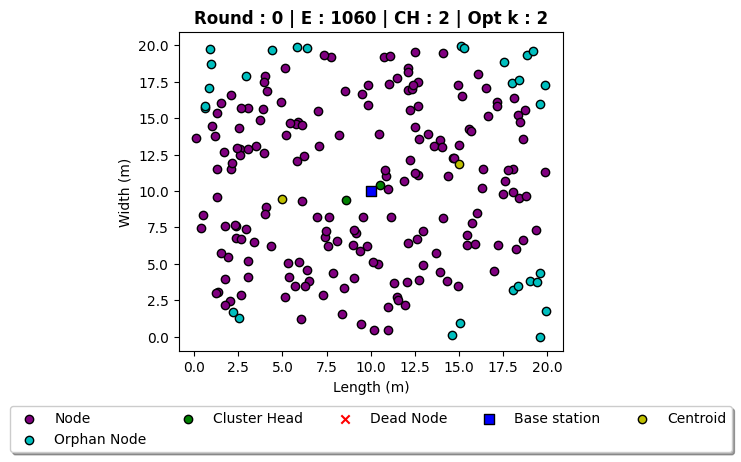

Round : 0 | PATH : [4, 1, 87, 0] | node.energy : 4.999999
Round : 0 | PATH : [8, 6, 11, 0] | node.energy : 4.999999
Round : 0 | PATH : [17, 32, 1, 0] | node.energy : 4.999999
Round : 0 | PATH : [18, 100, 1, 0] | node.energy : 4.999999
Round : 0 | PATH : [20, 2, 0] | node.energy : 4.999999
Round : 0 | PATH : [26, 1, 0] | node.energy : 4.999999
unreachable 29=> [29]
Round : 0 | PATH : [29] | node.energy : 4.999999
Round : 0 | PATH : [39, 1, 0] | node.energy : 4.999999
Round : 0 | PATH : [40, 6, 0] | node.energy : 4.999999
Round : 0 | PATH : [74, 2, 98, 0] | node.energy : 4.999999
Round : 0 | PATH : [81, 1, 0] | node.energy : 4.999999
Round : 0 | PATH : [111, 136, 0] | node.energy : 4.999999
Round : 0 | PATH : [121, 2, 0] | node.energy : 4.999999
Round : 0 | PATH : [134, 1, 0] | node.energy : 4.999999
Round : 0 | PATH : [141, 2, 0] | node.energy : 4.999999
Round : 0 | PATH : [143, 202, 0] | node.energy : 4.999999
Round : 0 | PATH : [149, 2, 0] | node.energy : 4.999999
Round : 0 | PATH : [

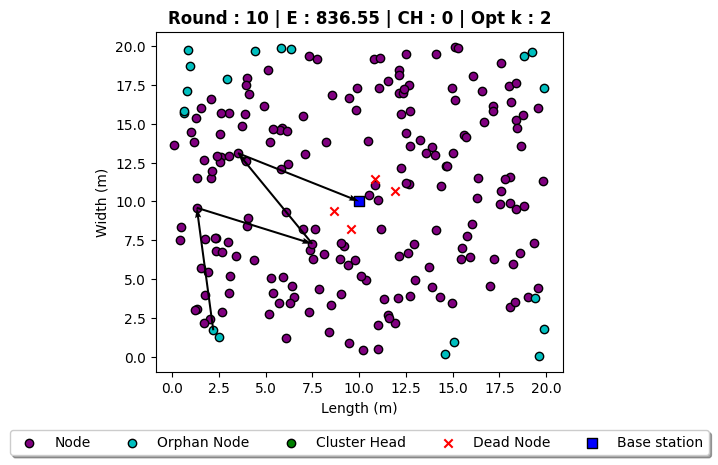

Round : 10 | PATH : [4, 1, 0] | node.energy : 4.999964314958732
Round : 10 | PATH : [8, 201, 0] | node.energy : 4.99996808755929
Round : 10 | PATH : [17, 1, 0] | node.energy : 4.498181777133637
Round : 10 | PATH : [29, 69, 0] | node.energy : 4.999967385821467
Round : 10 | PATH : [39, 135, 0] | node.energy : 4.999971196007683
Round : 10 | PATH : [40, 6, 63, 0] | node.energy : 4.999971085287562
Round : 10 | PATH : [81, 1, 0] | node.energy : 4.9999650773586595
Round : 10 | PATH : [111, 2, 0] | node.energy : 4.131446184587511
Round : 10 | PATH : [134, 1, 0] | node.energy : 4.532758117294252
Round : 10 | PATH : [141, 2, 0] | node.energy : 4.99997162520559
Round : 10 | PATH : [143, 3, 0] | node.energy : 4.999963452930559
Round : 10 | PATH : [149, 2, 173, 164, 0] | node.energy : 4.999972519511471
Round : 10 | PATH : [157, 5, 0] | node.energy : 4.999964497332716
Round : 10 | PATH : [163, 5, 0] | node.energy : 3.9802960880552183
Round : 10 | PATH : [179, 2, 0] | node.energy : 4.99996685290471
R

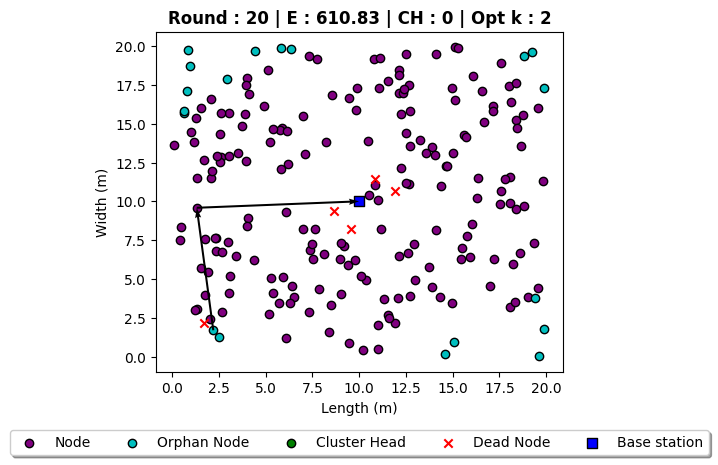

Round : 20 | PATH : [4, 1, 0] | node.energy : 4.999928249956544
Round : 20 | PATH : [8, 6, 0] | node.energy : 4.999939281533914
Round : 20 | PATH : [17, 139, 0] | node.energy : 4.498153277819679
Round : 20 | PATH : [29, 1, 0] | node.energy : 4.999931792274512
Round : 20 | PATH : [39, 1, 0] | node.energy : 4.999943306146874
Round : 20 | PATH : [40, 6, 0] | node.energy : 4.999938182455165
Round : 20 | PATH : [81, 1, 0] | node.energy : 4.999929928904082
Round : 20 | PATH : [111, 2, 0] | node.energy : 4.131417813412403
Round : 20 | PATH : [134, 1, 0] | node.energy : 4.5327288663705385
Round : 20 | PATH : [141, 2, 0] | node.energy : 4.999945454637149
Round : 20 | PATH : [143, 3, 0] | node.energy : 4.999928063712622
Round : 20 | PATH : [149, 118, 188, 1, 0] | node.energy : 4.999945559127684
Round : 20 | PATH : [157, 1, 83, 0] | node.energy : 4.999933803812507
Round : 20 | PATH : [163, 5, 123, 27, 0] | node.energy : 3.9802586791714307
Round : 20 | PATH : [179, 2, 0] | node.energy : 4.99993434

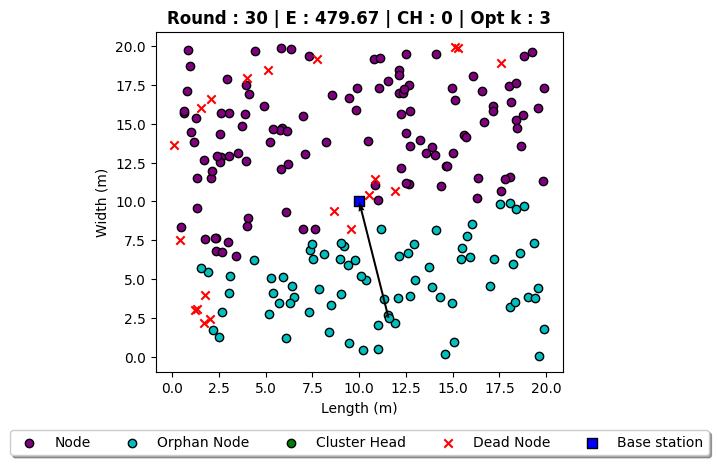

Round : 30 | PATH : [2, 71, 0] | node.energy : 3.2935923089204193
Round : 30 | PATH : [3, 0] | node.energy : 3.4396451732274267
Round : 30 | PATH : [11, 66, 0] | node.energy : 1.146269302744848
unreachable 12=> [12]
Round : 30 | PATH : [12] | node.energy : 1.4699423077934886
Round : 30 | PATH : [14, 0] | node.energy : 1.003447240195107
Round : 30 | PATH : [16, 0] | node.energy : 2.7278874340482506
Round : 30 | PATH : [20, 2, 0] | node.energy : 0.9257507257164322
Round : 30 | PATH : [21, 0] | node.energy : 2.8433939878854373
Round : 30 | PATH : [22, 0] | node.energy : 2.5245754117183408
Round : 30 | PATH : [23, 0] | node.energy : 4.000021891034898
Round : 30 | PATH : [27, 0] | node.energy : 1.847910428416873
Round : 30 | PATH : [37, 0] | node.energy : 4.1440484999925085
Round : 30 | PATH : [51, 0] | node.energy : 3.9849966738178635
Round : 30 | PATH : [52, 0] | node.energy : 3.243702147900921
Round : 30 | PATH : [54, 0] | node.energy : 2.048431949496868
Round : 30 | PATH : [55, 203, 0] 

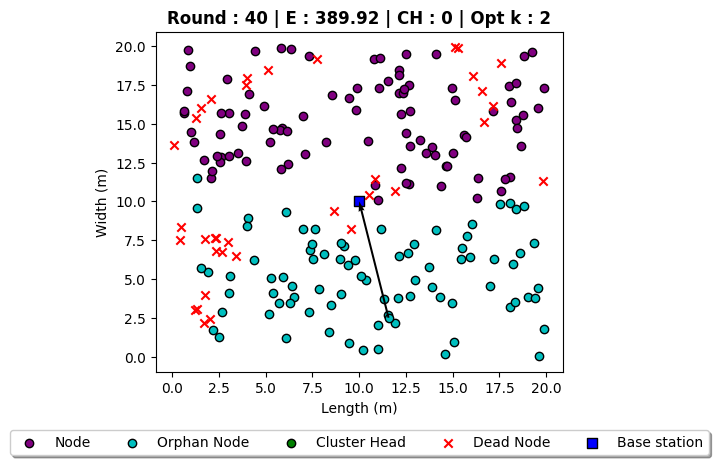

Round : 40 | PATH : [2, 168, 0] | node.energy : 3.2935762855421693
Round : 40 | PATH : [3, 0] | node.energy : 3.4396259831496705
Round : 40 | PATH : [5, 0] | node.energy : 0.23464886648631433
Round : 40 | PATH : [11, 0] | node.energy : 1.1462437446504792
Round : 40 | PATH : [12, 137, 0] | node.energy : 1.4699179662794535
Round : 40 | PATH : [14, 0] | node.energy : 1.0034182945990826
Round : 40 | PATH : [16, 0] | node.energy : 2.727864437962494
Round : 40 | PATH : [20, 193, 0] | node.energy : 0.9257245844418932
Round : 40 | PATH : [21, 11, 0] | node.energy : 2.8433750371900888
Round : 40 | PATH : [22, 0] | node.energy : 2.5245517740638745
Round : 40 | PATH : [23, 0] | node.energy : 4.0000085490502695
Round : 40 | PATH : [27, 0] | node.energy : 1.847889637365648
Round : 40 | PATH : [37, 0] | node.energy : 4.144034295711412
Round : 40 | PATH : [44, 12, 23, 0] | node.energy : 1.0336060290948215
Round : 40 | PATH : [50, 0] | node.energy : 2.0153903094234553
Round : 40 | PATH : [51, 0] | nod

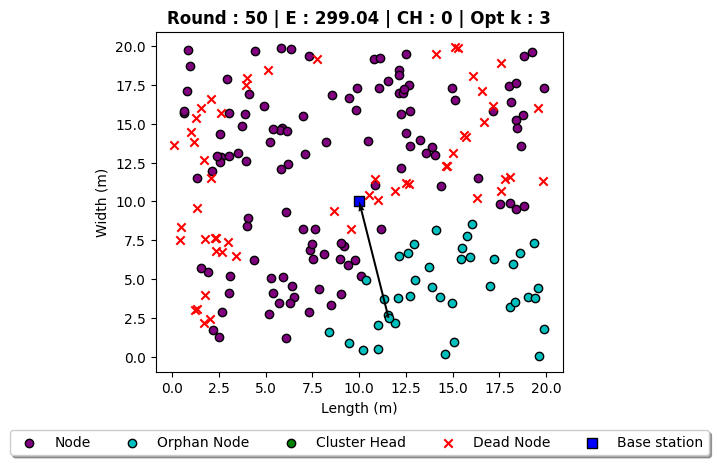

Round : 50 | PATH : [2, 0] | node.energy : 3.2935538555938253
Round : 50 | PATH : [3, 0] | node.energy : 3.43960764656366
Round : 50 | PATH : [11, 6, 0] | node.energy : 1.1462178356213637
Round : 50 | PATH : [14, 0] | node.energy : 1.0033881411099284
Round : 50 | PATH : [20, 2, 194, 0] | node.energy : 0.9257007848960753
Round : 50 | PATH : [21, 0] | node.energy : 2.8433555798977492
Round : 50 | PATH : [23, 0] | node.energy : 3.99999456432335
Round : 50 | PATH : [27, 0] | node.energy : 1.8478677565540698
Round : 50 | PATH : [37, 0] | node.energy : 4.144016235733487
Round : 50 | PATH : [51, 0] | node.energy : 3.984963400384835
Round : 50 | PATH : [60, 116, 0] | node.energy : 3.6621853729805856
Round : 50 | PATH : [72, 0] | node.energy : 1.8434498273612023
Round : 50 | PATH : [74, 119, 0] | node.energy : 0.29380701769249484
Round : 50 | PATH : [77, 0] | node.energy : 2.456127428737803
Round : 50 | PATH : [89, 0] | node.energy : 2.6693352029532194
Round : 50 | PATH : [90, 0] | node.energy 

: 

In [7]:
node_Q_Learning    = createNetworks(N, P, L)
Q_Learning = networkEnvironment(node_Q_Learning, "Q-Learning", False, 10)
Q_Learning_aliveNode, Q_Learning_EnergyNode, Q_Learning_NodeFailure, Q_Learning_PDR = Q_Learning.startSimulation(200)
# Play the sound


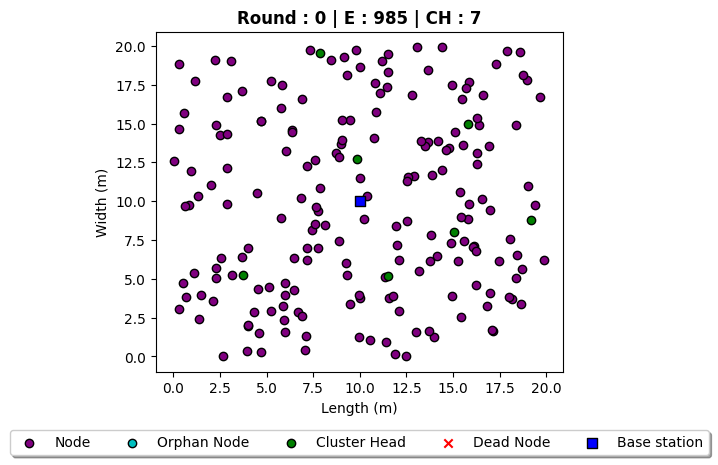

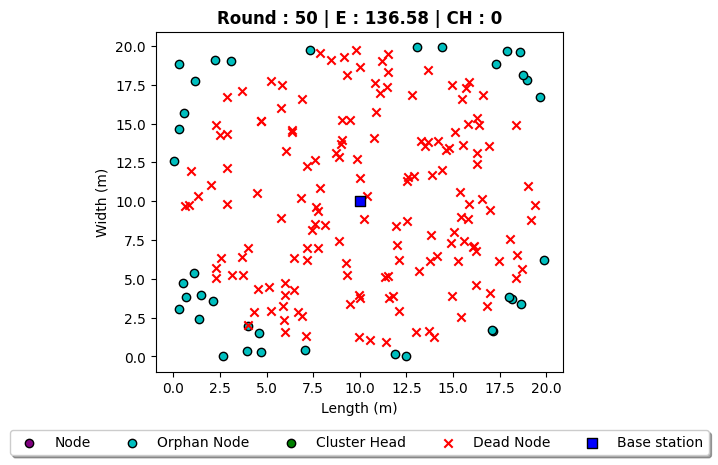

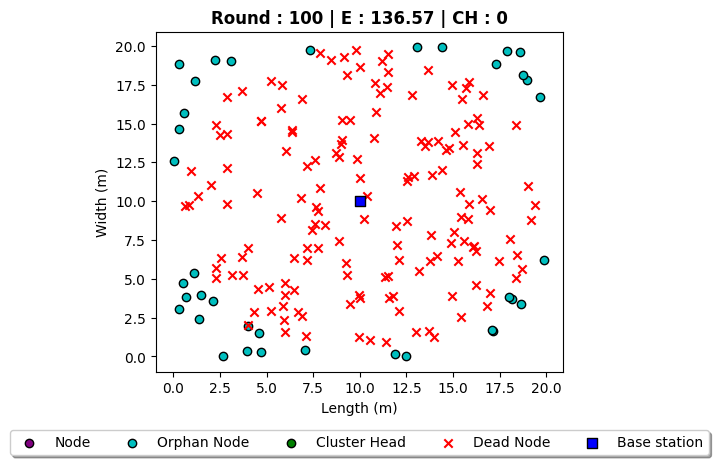

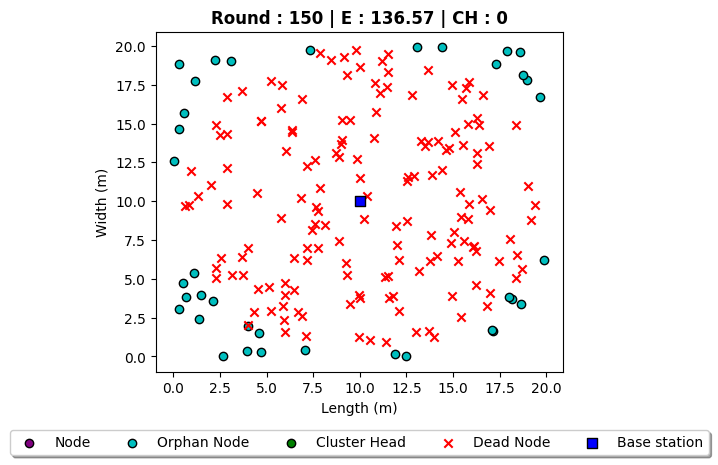

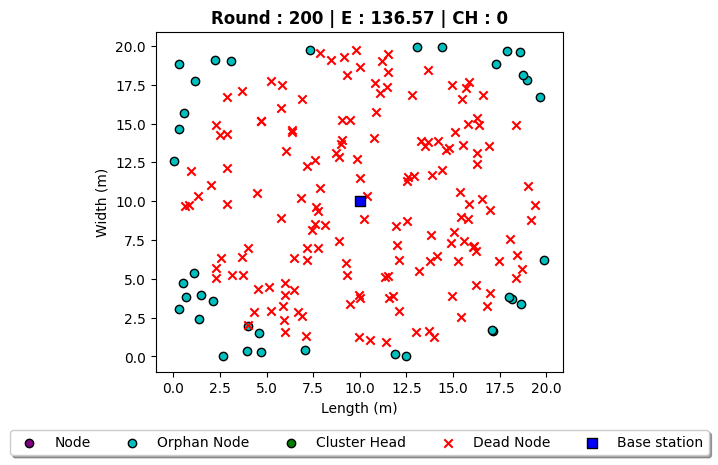

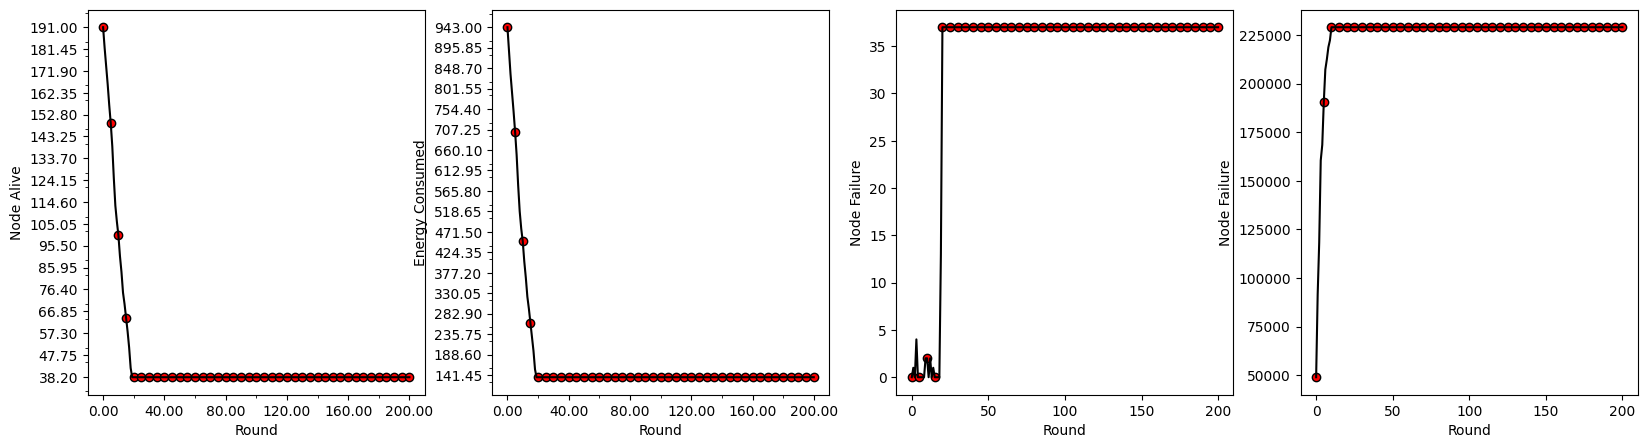

In [ ]:
node_LEACH    = createNetworks(N, P, L)
LEACH = networkEnvironment(node_LEACH, "LEACH", False, 50)
LEACH_aliveNode, LEACH_EnergyNode, LEACH_NodeFailure, LEACH_PDR = LEACH.startSimulation(200)

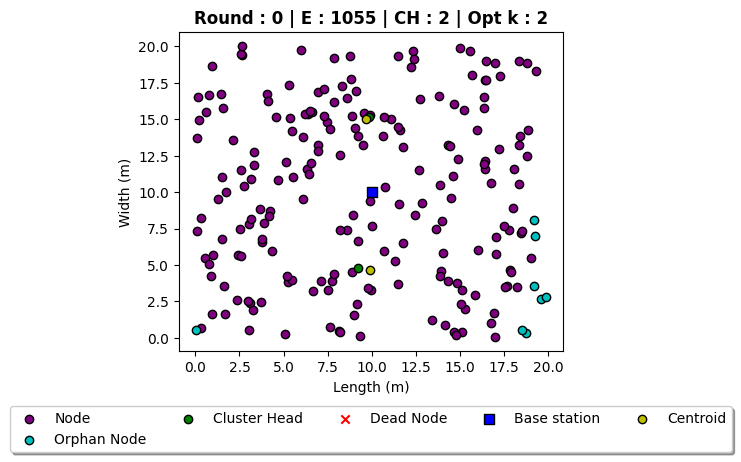

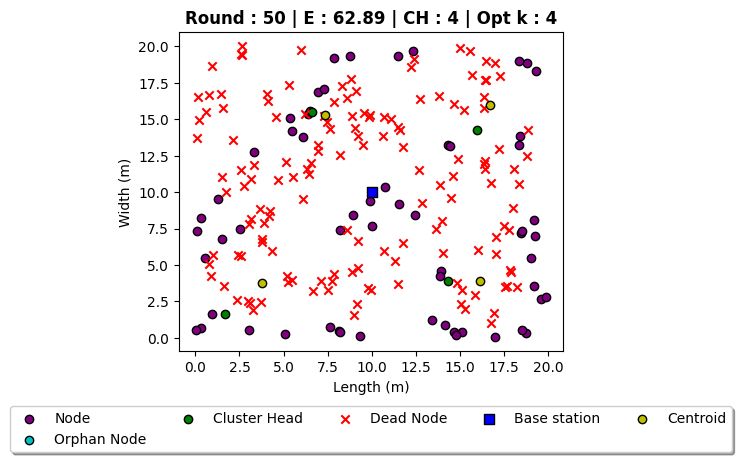

e:\Bagas\Python3.7.3\lib\site-packages\ipykernel_launcher.py:260: RuntimeWarning: invalid value encountered in true_divide
e:\Bagas\Python3.7.3\lib\site-packages\ipykernel_launcher.py:281: RuntimeWarning: Mean of empty slice.


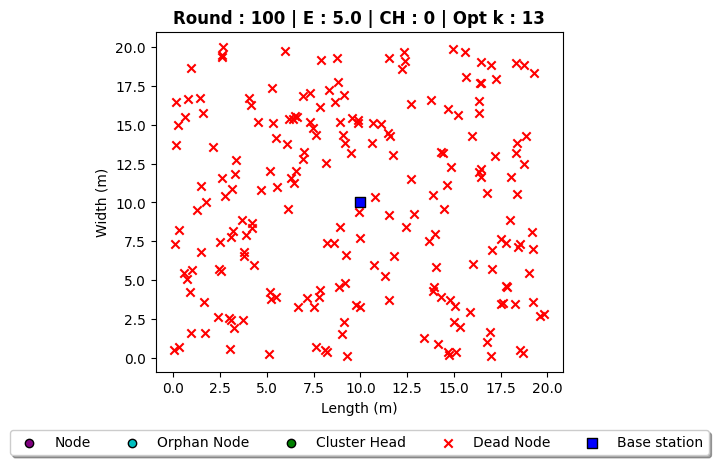

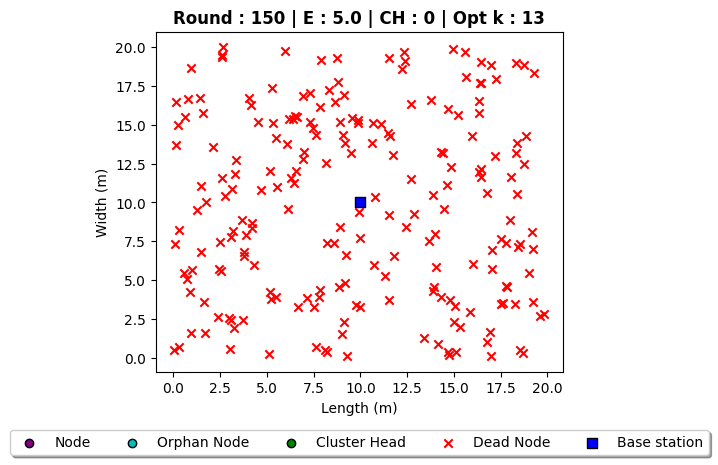

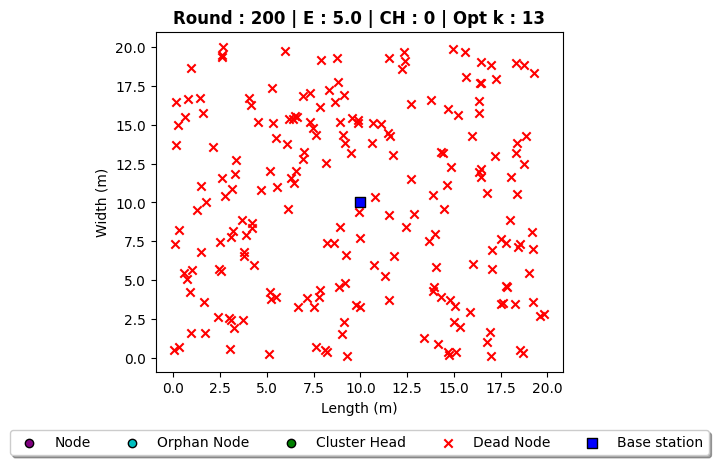

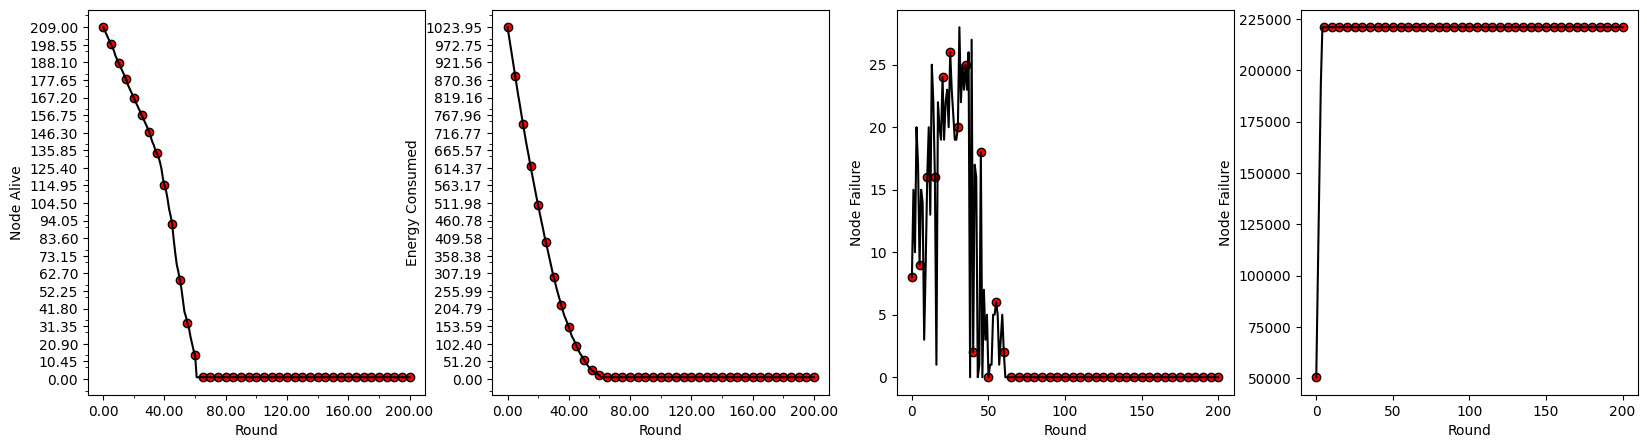

In [ ]:
node_K_Means    = createNetworks(N, P, L)
K_Means = networkEnvironment(node_K_Means, "K-Means", False, 50)
K_Means_aliveNode, K_Means_EnergyNode, K_Means_NodeFailure, K_Means_PDR = K_Means.startSimulation(200)

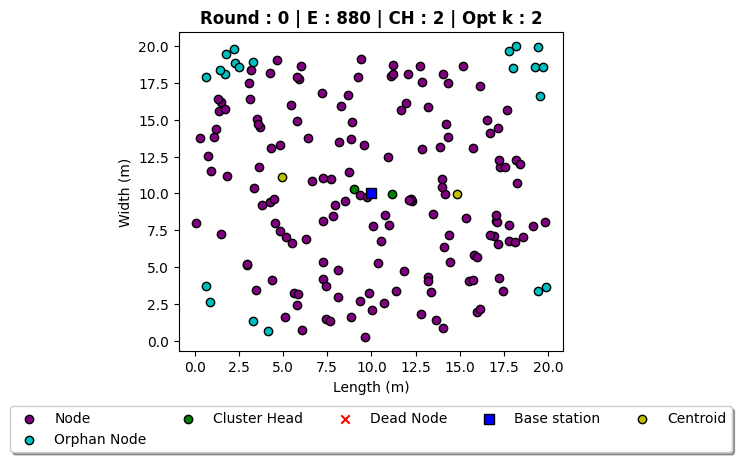

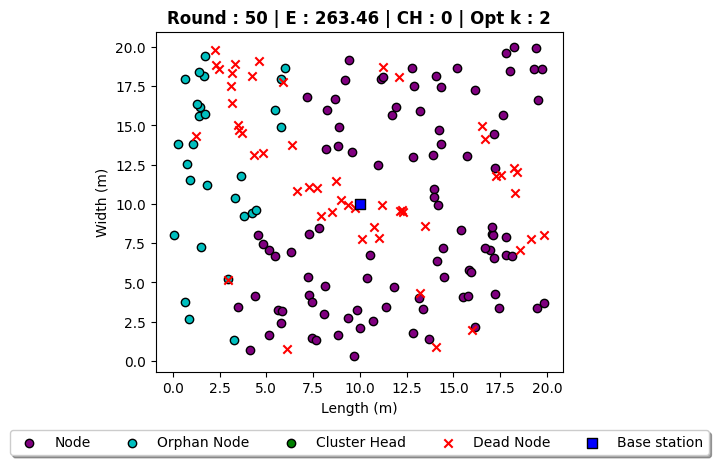

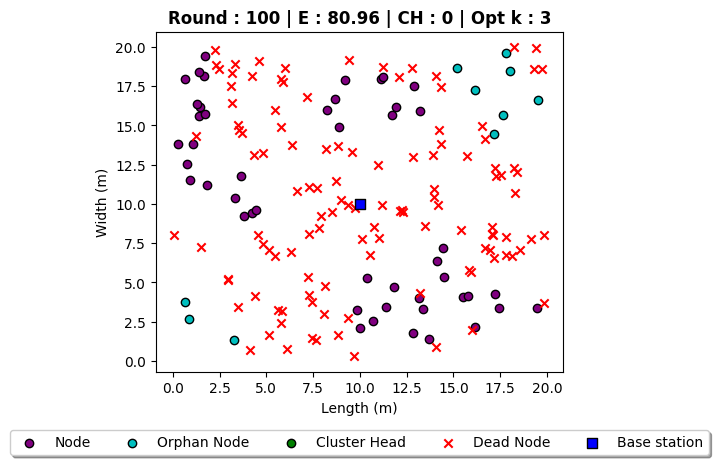

e:\Bagas\Python3.7.3\lib\site-packages\ipykernel_launcher.py:281: RuntimeWarning: Mean of empty slice.


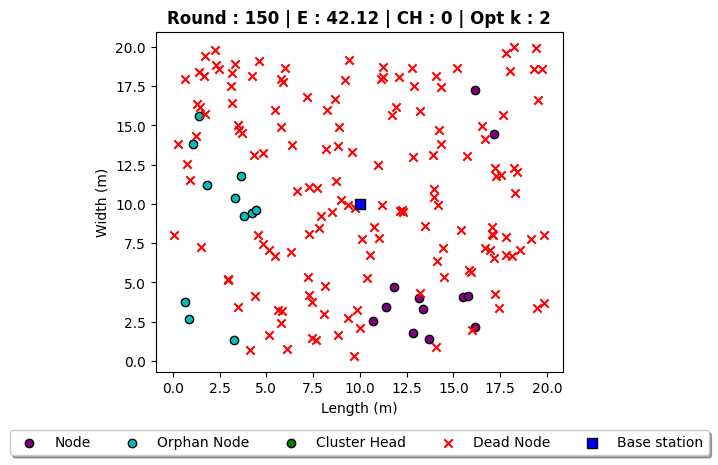

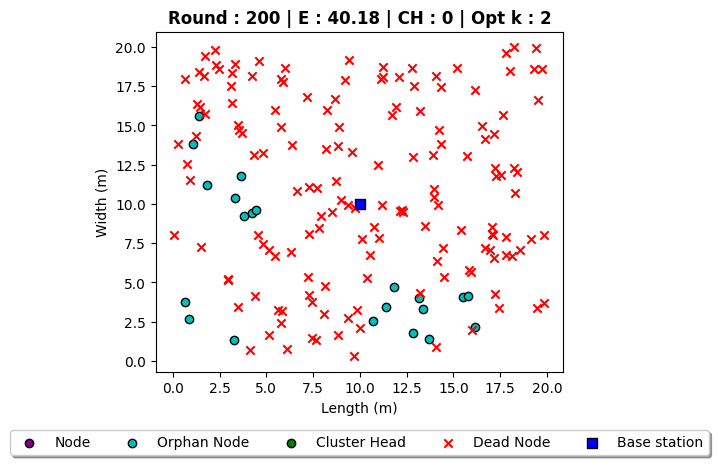

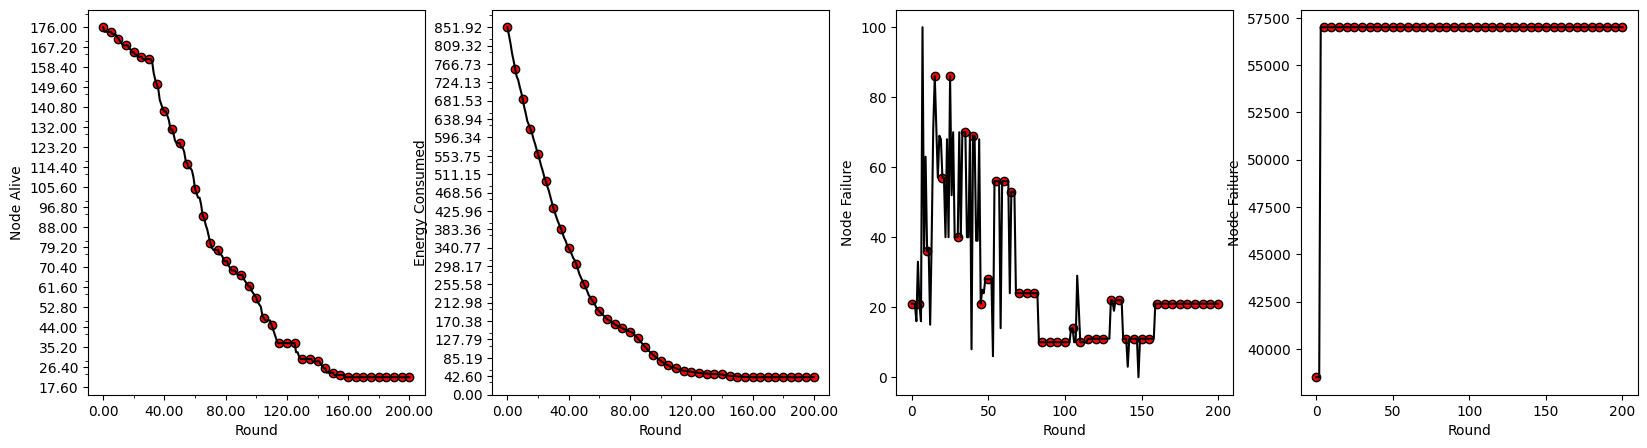

In [ ]:
node_DECKS    = createNetworks(N, P, L)
DECKS = networkEnvironment(node_DECKS, "DECKS", False, 50)
DECKS_aliveNode, DECKS_EnergyNode, DECKS_NodeFailure, DECKS_PDR = DECKS.startSimulation(200)

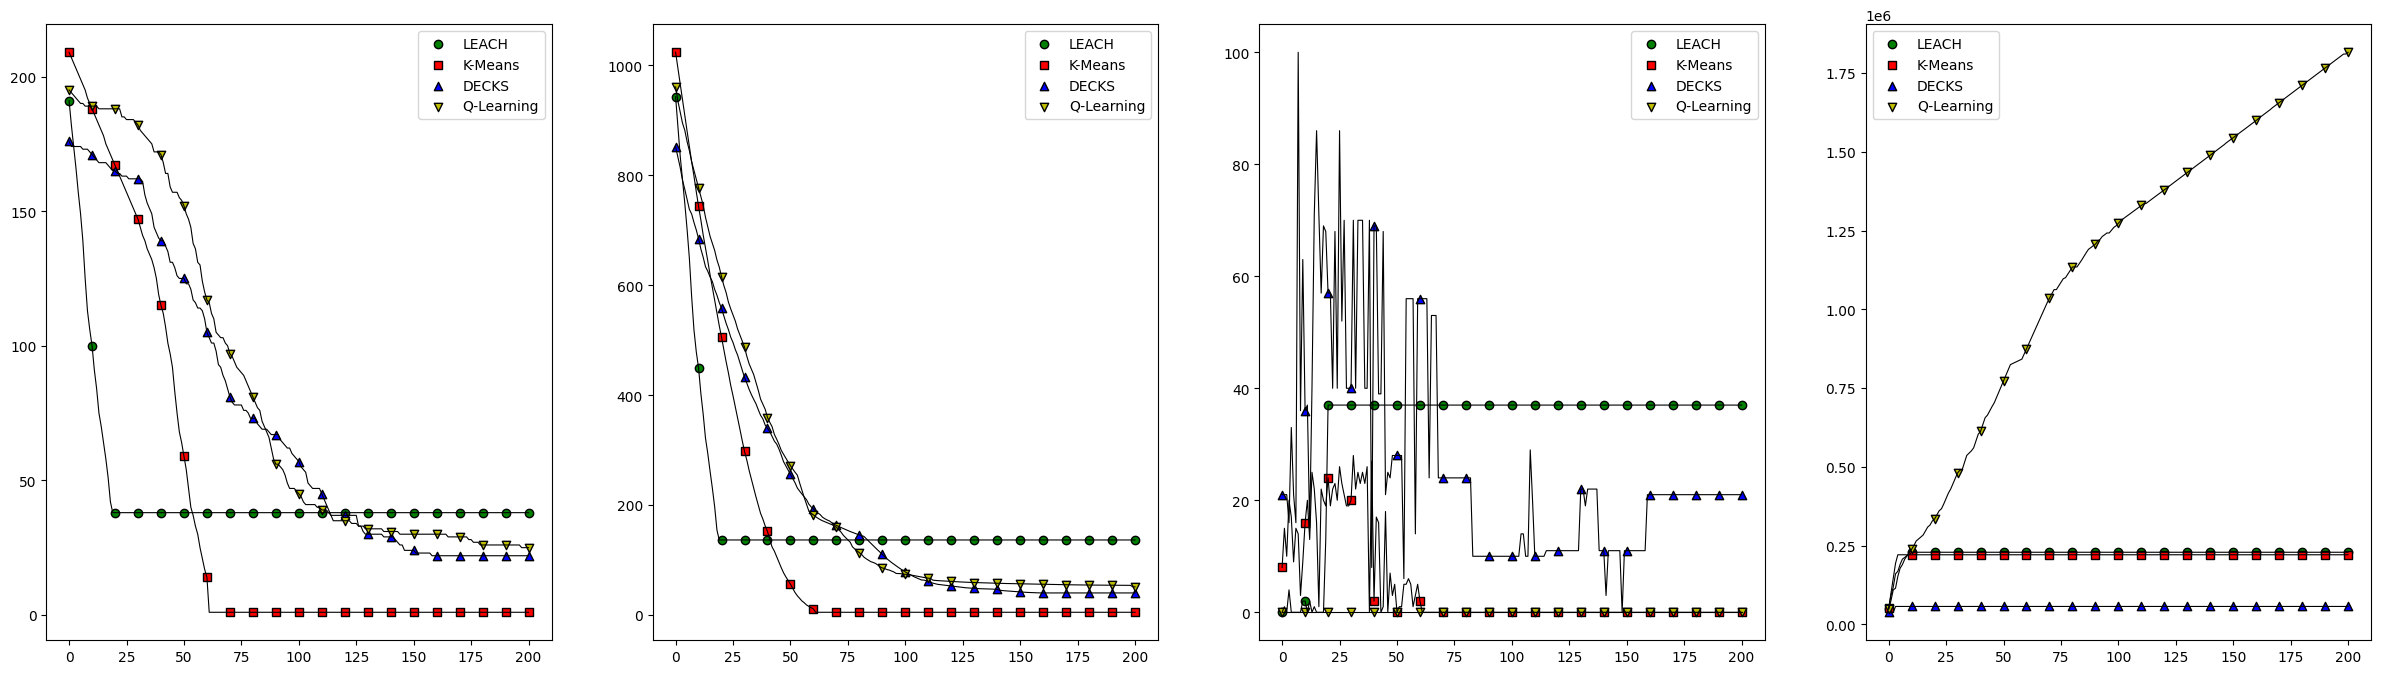

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(30, 8))

alive = [LEACH_aliveNode, K_Means_aliveNode, DECKS_aliveNode, Q_Learning_aliveNode]
PDR = [LEACH_PDR, K_Means_PDR, DECKS_PDR, Q_Learning_PDR]
energy = [LEACH_EnergyNode, K_Means_EnergyNode, DECKS_EnergyNode, Q_Learning_EnergyNode]
nodeFailure = [LEACH_NodeFailure, K_Means_NodeFailure, DECKS_NodeFailure, Q_Learning_NodeFailure]

labels = ['LEACH', 'K-Means', 'DECKS', 'Q-Learning']
rounds = [i for i in range(201)]
data = [alive, energy, nodeFailure, PDR]
data_label = ['alive', 'energy', 'node failure', 'packet sent']
markers = ['o', 's', '^', 'v']
colors = ['g', 'r', 'b', 'y']
hop = 10

for i in range(len(data)) :
    # looping element inside the data
    df = {}
    for j in range(len(data[i])):
        # looping element inside the each parameter
        df[labels[j]] = data[i][j]
        ax[i].plot(rounds, data[i][j], color='k', linewidth=0.8)
        ax[i].scatter(rounds[::hop], data[i][j][::hop], label=labels[j], marker=markers[j], color=colors[j], edgecolors='k')
        ax[i].legend()
    pd.DataFrame(df).to_excel(f"Data {data_label[i]}.xlsx", index=False)
plt.show()

In [ ]:

play_sound()

In [ ]:
a = [0]
b = [1,2,3]
a = a+b
print(a)
for i in range(len(a)-1):
    print(a[i])

[0, 1, 2, 3]
0
1
2


In [ ]:
count_exploration = 0
count_exploitation = 0
for _ in range(0, 10000):
    if random.random() > 0.02:
        count_exploitation += 1
    else:
        count_exploration += 1

print(f"exploitation : {count_exploitation} | exploration : {count_exploration}")

exploitation : 9789 | exploration : 211


|